<a href="https://colab.research.google.com/github/BrunoPinos/Categoriser-automatiquement-des-questions/blob/add_classifier/P5_supervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [69]:
# data analysis and wrangling
import pandas as pd
from scipy import stats

# visualization
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np

# text
from gensim.models import LdaMulticore
from gensim.models import Phrases, CoherenceModel
from gensim.matutils import corpus2csc
from IPython.display import display, HTML

# Save objects
import joblib

# Machine learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score

# Set working directory
import time
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/P5')

# Data table display for Pandas dataframes
from google.colab import data_table
%load_ext google.colab.data_table

The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


Import

In [70]:
df = joblib.load('df.sav')
texts_cleaned = joblib.load('texts_cleaned.sav')
dictionary = joblib.load('dictionary.sav')

Create the main dataframe with Tags and Text (cleaned) features

In [71]:
df['Text'] = texts_cleaned

df.drop(['Body', 'Title'], axis=1, inplace=True)

Split Tag

In [72]:
list_tags = df.Tags.apply(lambda tags: tags[1:-1].split('><'))
list_tags

Id
10000005                           [php, arrays, sorting]
10000083    [javascript, events, event-handling, handler]
10000335                          [linux, gdb, libc, ldd]
10003270                         [c, arrays, gcc, struct]
10003562            [objective-c, ios, storyboard, segue]
                                ...                      
1213074           [wpf, winforms, interop, drag-and-drop]
1213127         [java, mysql, database-connection, sleep]
1213137                             [iphone, uitableview]
1213144                      [sql-server-ce, data-paging]
1213217              [perl, dependencies, module, legacy]
Name: Tags, Length: 101366, dtype: object

In [73]:
list_tags_total = list()

for row in list_tags:
  for word in row:
    list_tags_total.append(word)

list_tags_total = pd.Series(list_tags_total)
print(f'There are {list_tags_total.nunique()} Tags')

There are 14413 Tags


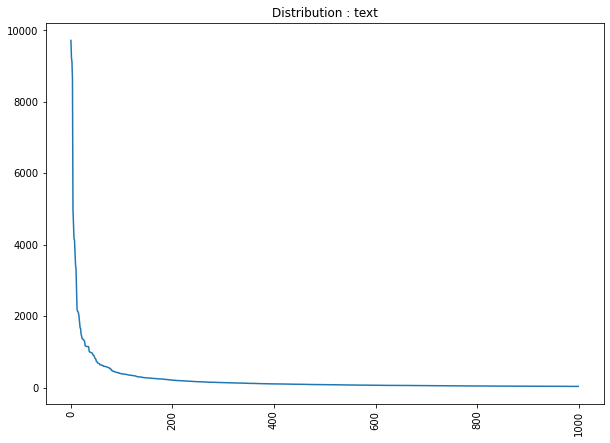

In [74]:
data_count = list_tags_total.value_counts()
fig = plt.figure(1, figsize=(10, 7))
sn.lineplot(x = range(0, 1000), y = data_count[0:1000])
plt.xticks(rotation=90)
plt.title('Distribution : text')
plt.show()

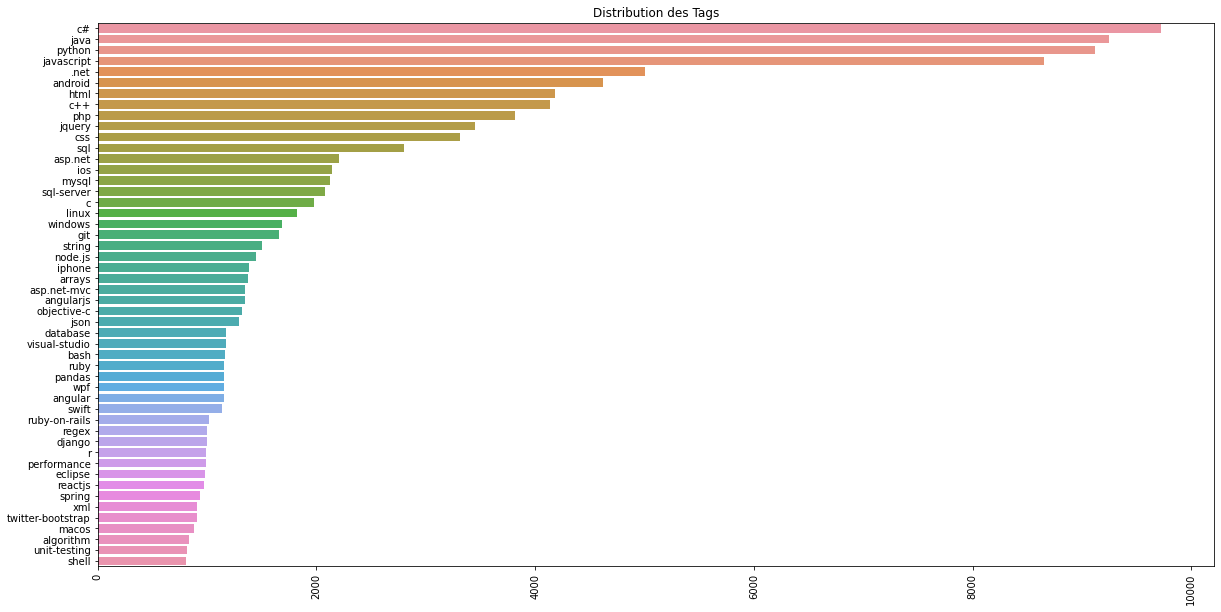

In [75]:
fig = plt.figure(1, figsize=(20, 10))
sn.barplot(x = data_count[0:50].values, y = data_count[0:50].index)
plt.xticks(rotation=90)
plt.title('Distribution des Tags')
plt.show()

In [76]:
list_tags

Id
10000005                           [php, arrays, sorting]
10000083    [javascript, events, event-handling, handler]
10000335                          [linux, gdb, libc, ldd]
10003270                         [c, arrays, gcc, struct]
10003562            [objective-c, ios, storyboard, segue]
                                ...                      
1213074           [wpf, winforms, interop, drag-and-drop]
1213127         [java, mysql, database-connection, sleep]
1213137                             [iphone, uitableview]
1213144                      [sql-server-ce, data-paging]
1213217              [perl, dependencies, module, legacy]
Name: Tags, Length: 101366, dtype: object

In [77]:
n = 10
i = 0
good_tags = data_count[0:n].index
list_tag_n = list()

for row in list_tags:
  list_tag_n.append(list())
  for word in row:
    if word in good_tags:
      list_tag_n[i].append(word)
  i += 1

In [78]:
df['Tags'] = list_tag_n
df = df.loc[df['Tags'].apply(len) > 0]

In [79]:
df

,Tags,Text
Id,,
10000005,[php],"[php, sort, array, field, possible, duplicate,..."
10000083,[javascript],"[javascript, event, handler, parameter, want, ..."
10003683,[javascript],"[extract, number, string, javascript, string, ..."
10006459,[javascript],"[regular, expression, address, validation, wan..."
10006529,[javascript],"[change, color, highchart, use, highchart, mak..."
...,...,...
1212838,[c#],"[send, mails, image, inline, use, smtpclient, ..."
1212882,[java],"[convert, byte, array, image, java, without, k..."
1212914,[c#],"[enable, scroll, microsoft, chart, control, wi..."


In [80]:
# I binarize tags
binarizer = MultiLabelBinarizer()
y = binarizer.fit_transform(df['Tags'])

# I transform the text with dictionary
X = df['Text'].apply(dictionary.doc2bow)
X = corpus2csc(X, num_terms=len(dictionary)).transpose()

In [81]:
X_train, X_test, y_train, y_test = \
                        train_test_split(X,
                                         y,
                                         test_size=0.20,
                                         shuffle=True,
                                         random_state=0)

**Naive bayesien**

In [82]:
estimator_nb = Pipeline([('tfidf', TfidfTransformer()), 
                         ('nb', OneVsRestClassifier(MultinomialNB()))
                        ])

parameters = {'nb__estimator__alpha': [1.0, 3e-1, 1e-1, 3e-2, 1e-2]}

nb_grid = GridSearchCV(estimator_nb,
                        param_grid=parameters,
                        scoring='jaccard_samples',
                        n_jobs=-1,
                        verbose=1,
                        cv=5)

nb_grid.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    5.9s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('tfidf',
                                        TfidfTransformer(norm='l2',
                                                         smooth_idf=True,
                                                         sublinear_tf=False,
                                                         use_idf=True)),
                                       ('nb',
                                        OneVsRestClassifier(estimator=MultinomialNB(alpha=1.0,
                                                                                    class_prior=None,
                                                                                    fit_prior=True),
                                                            n_jobs=None))],
                                verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'nb__estimator__alpha': [1.0, 0.3, 0.1, 0.0

In [83]:
nb_grid.best_params_

{'nb__estimator__alpha': 0.03}

In [84]:
nb_grid.best_score_

0.4442073088366384

In [85]:
print("Score sur test set: ",
      round(nb_grid.score(X_test, y_test), 3))

Score sur test set:  0.461


Score

In [86]:
results = pd.DataFrame({})

jaccard_macro = jaccard_score(y_test, nb_grid.predict(X_test), average='macro')
f1_macro = f1_score(y_test, nb_grid.predict(X_test), average='macro')
f1_sample = f1_score(y_test, nb_grid.predict(X_test), average='samples')

time = %timeit -o nb_grid.predict(X_test)

results = results.append(pd.DataFrame({'Modèle': ['Naive_bayesian'],
                                       'jaccard_samples': round(
                                           nb_grid.score(X_test, y_test), 3),
                                       'jaccard_macro': jaccard_macro,
                                       'f1_macro': f1_macro,
                                       'f1_sample': f1_sample,
                                       'Time_ms': time.best*1000,
                                       'Cv_score(jaccard_samples)':
                                       nb_grid.best_score_}),
                         ignore_index=True)

results.round(3)

10 loops, best of 5: 37.9 ms per loop


,Modèle,jaccard_samples,jaccard_macro,f1_macro,f1_sample,Time_ms,Cv_score(jaccard_samples)
0,Naive_bayesian,0.461,0.423,0.576,0.475,37.858,0.444


**SVM**

In [87]:
estimator_svm = Pipeline([('tfidf', TfidfTransformer()), 
                          ('svm',
                           MultiOutputClassifier(LinearSVC(max_iter=1000)))
                          ])

parameters = {'svm__estimator__C': [1, 10, 30]}

svm_grid = GridSearchCV(estimator_svm,
                        param_grid=parameters,
                        scoring='jaccard_samples',
                        n_jobs=-1,
                        verbose=1,
                        cv=5)

svm_grid.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  2.0min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('tfidf',
                                        TfidfTransformer(norm='l2',
                                                         smooth_idf=True,
                                                         sublinear_tf=False,
                                                         use_idf=True)),
                                       ('svm',
                                        MultiOutputClassifier(estimator=LinearSVC(C=1.0,
                                                                                  class_weight=None,
                                                                                  dual=True,
                                                                                  fit_intercept=True,
                                                                                  intercept_scaling=1,
                                           

In [88]:
svm_grid.best_params_

{'svm__estimator__C': 1}

Score

In [89]:
jaccard_macro = jaccard_score(y_test, svm_grid.predict(X_test), average='macro')
f1_macro = f1_score(y_test, svm_grid.predict(X_test), average='macro')
f1_sample = f1_score(y_test, svm_grid.predict(X_test), average='samples')

time = %timeit -o svm_grid.predict(X_test)

results = results.append(pd.DataFrame({'Modèle': ['LinearSVC'],
                                       'jaccard_samples': round(
                                           svm_grid.score(X_test, y_test), 3),
                                       'jaccard_macro': jaccard_macro,
                                       'f1_macro': f1_macro,
                                       'f1_sample': f1_sample,
                                       'Time_ms': time.best*1000,
                                       'Cv_score(jaccard_samples)':
                                       svm_grid.best_score_}),
                         ignore_index=True)

results.round(3)

100 loops, best of 5: 13 ms per loop


,Modèle,jaccard_samples,jaccard_macro,f1_macro,f1_sample,Time_ms,Cv_score(jaccard_samples)
0,Naive_bayesian,0.461,0.423,0.576,0.475,37.858,0.444
1,LinearSVC,0.701,0.631,0.760,0.724,12.982,0.689


**MLPclassifier**

In [90]:
estimator_mlp = Pipeline([('tfidf', TfidfTransformer()), 
                          ('mlp', MLPClassifier())])

parameters = {
    'mlp__max_iter' : [50], #maximum iteration
}

mlp_grid = GridSearchCV(estimator_mlp,
                        param_grid=parameters,
                        scoring='jaccard_samples',
                        n_jobs=-1,
                        verbose=1,
                        cv=5)

mlp_grid.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.8min finished
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('tfidf',
                                        TfidfTransformer(norm='l2',
                                                         smooth_idf=True,
                                                         sublinear_tf=False,
                                                         use_idf=True)),
                                       ('mlp',
                                        MLPClassifier(activation='relu',
                                                      alpha=0.0001,
                                                      batch_size='auto',
                                                      beta_1=0.9, beta_2=0.999,
                                                      early_stopping=False,
                                                      epsilon=1e-08,
                                                      hidden_layer_sizes=(100,),
           

In [91]:
mlp_grid.best_params_

{'mlp__max_iter': 50}

Score

In [92]:
jaccard_macro = jaccard_score(y_test, mlp_grid.predict(X_test), average='macro')
f1_macro = f1_score(y_test, mlp_grid.predict(X_test), average='macro')
f1_sample = f1_score(y_test, mlp_grid.predict(X_test), average='samples')

time = %timeit -o mlp_grid.predict(X_test)

results = results.append(pd.DataFrame({'Modèle': ['MLP_classifier'],
                                       'jaccard_samples': round(
                                           mlp_grid.score(X_test, y_test), 3),
                                       'jaccard_macro': jaccard_macro,
                                       'f1_macro': f1_macro,
                                       'f1_sample': f1_sample,
                                       'Time_ms': time.best*1000,
                                       'Cv_score(jaccard_samples)':
                                       mlp_grid.best_score_}),
                         ignore_index=True)

results.round(3)

10 loops, best of 5: 49.7 ms per loop


,Modèle,jaccard_samples,jaccard_macro,f1_macro,f1_sample,Time_ms,Cv_score(jaccard_samples)
0,Naive_bayesian,0.461,0.423,0.576,0.475,37.858,0.444
1,LinearSVC,0.701,0.631,0.760,0.724,12.982,0.689
2,MLP_classifier,0.709,0.612,0.747,0.739,49.742,0.696


**Xgboost**

In [93]:
estimator_xgb = Pipeline([('tfidf', TfidfTransformer()), 
                         ('xgb', OneVsRestClassifier(
                             GradientBoostingClassifier())),
                        ])

parameters = {
    'xgb__estimator__n_estimators' : [100], #nombre d'arbres de décision
    'xgb__estimator__min_samples_leaf' : [2], #nombre de feuilles minimales 
    'xgb__estimator__max_features': ['sqrt'] #nombre de features observées
}

xgb_grid = GridSearchCV(estimator_xgb,
                        param_grid=parameters,
                        scoring='jaccard_samples',
                        n_jobs=-1,
                        verbose=1,
                        cv=5)

xgb_grid.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.5min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('tfidf',
                                        TfidfTransformer(norm='l2',
                                                         smooth_idf=True,
                                                         sublinear_tf=False,
                                                         use_idf=True)),
                                       ('xgb',
                                        OneVsRestClassifier(estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                                                                 criterion='friedman_mse',
                                                                                                 init=None,
                                                                                                 learning_rate=0.1,
                                                                        

In [94]:
xgb_grid.best_params_

{'xgb__estimator__max_features': 'sqrt',
 'xgb__estimator__min_samples_leaf': 2,
 'xgb__estimator__n_estimators': 100}

In [95]:
jaccard_macro = jaccard_score(y_test, xgb_grid.predict(X_test), average='macro')
f1_macro = f1_score(y_test, xgb_grid.predict(X_test), average='macro')
f1_sample = f1_score(y_test, xgb_grid.predict(X_test), average='samples')

time = %timeit -o xgb_grid.predict(X_test)

results = results.append(pd.DataFrame({'Modèle': ['XGBoost'],
                                       'jaccard_samples': round(
                                           xgb_grid.score(X_test, y_test), 3),
                                       'jaccard_macro': jaccard_macro,
                                       'f1_macro': f1_macro,
                                       'f1_sample': f1_sample,
                                       'Time_ms': time.best*1000,
                                       'Cv_score(jaccard_samples)':
                                       xgb_grid.best_score_}),
                         ignore_index=True)

results.round(3)

10 loops, best of 5: 170 ms per loop


,Modèle,jaccard_samples,jaccard_macro,f1_macro,f1_sample,Time_ms,Cv_score(jaccard_samples)
0,Naive_bayesian,0.461,0.423,0.576,0.475,37.858,0.444
1,LinearSVC,0.701,0.631,0.760,0.724,12.982,0.689
2,MLP_classifier,0.709,0.612,0.747,0.739,49.742,0.696
3,XGBoost,0.354,0.323,0.464,0.364,169.783,0.331


**RandomForest**

In [96]:
estimator_rf = Pipeline([('tfidf', TfidfTransformer()), 
                         ('rf', RandomForestClassifier()),
                        ])

parameters = {
    'rf__n_estimators' : [100], #nombre d'arbres de décision
    'rf__min_samples_leaf' : [5], #nombre de feuilles minimales 
    'rf__max_features': ['auto'] #nombre de features observées
}

rf_grid = GridSearchCV(estimator_rf,
                       param_grid=parameters,
                       scoring='jaccard_samples',
                       n_jobs=-1,
                       verbose=1,
                       cv=5)

rf_grid.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.1min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('tfidf',
                                        TfidfTransformer(norm='l2',
                                                         smooth_idf=True,
                                                         sublinear_tf=False,
                                                         use_idf=True)),
                                       ('rf',
                                        RandomForestClassifier(bootstrap=True,
                                                               ccp_alpha=0.0,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='auto',
                                                 

In [97]:
rf_grid.best_params_

{'rf__max_features': 'auto',
 'rf__min_samples_leaf': 5,
 'rf__n_estimators': 100}

Score

In [98]:
jaccard_macro = jaccard_score(y_test, rf_grid.predict(X_test), average='macro')
f1_macro = f1_score(y_test, rf_grid.predict(X_test), average='macro')
f1_sample = f1_score(y_test, rf_grid.predict(X_test), average='samples')

time = %timeit -o rf_grid.predict(X_test)

results = results.append(pd.DataFrame({'Modèle': ['XGBoost'],
                                       'jaccard_samples': round(
                                           rf_grid.score(X_test, y_test), 3),
                                       'jaccard_macro': jaccard_macro,
                                       'f1_macro': f1_macro,
                                       'f1_sample': f1_sample,
                                       'Time_ms': time.best*1000,
                                       'Cv_score(jaccard_samples)':
                                       rf_grid.best_score_}),
                         ignore_index=True)

results.round(3)

1 loop, best of 5: 1.06 s per loop


,Modèle,jaccard_samples,jaccard_macro,f1_macro,f1_sample,Time_ms,Cv_score(jaccard_samples)
0,Naive_bayesian,0.461,0.423,0.576,0.475,37.858,0.444
1,LinearSVC,0.701,0.631,0.760,0.724,12.982,0.689
2,MLP_classifier,0.709,0.612,0.747,0.739,49.742,0.696
3,XGBoost,0.354,0.323,0.464,0.364,169.783,0.331
4,XGBoost,0.606,0.540,0.677,0.622,1058.588,0.585
